## 0C - Linear regression

Authors: Noemi Anau Montel, James Alvey, Christoph Weniger

Last update: 27 April 2023

**Purpose**: A first non-trivial example with vector-shaped data.

**Key take-away messages**: Low-dimensional linear regression tasks can be performed with standard Swyft functionality and networks.

### Code

In [27]:
import numpy as np
import pylab as plt
import torch
import swyft

We now consider a simple linear regression problem. Our data vector $\mathbf x$ has now length 100, and we consider three model parameters $\mathbf z$ which for the constant, linear and quatractic contribution.

$$ 
x_i = z[0] + z[1]\cdot y_i + z[2] \cdot y_i^2
$$

where $\mathbf y$ is a linear grid.

In [28]:
N = 10_000  # Number of samples
Nbins = 100
z = np.random.rand(N, 3)*2 - 1
y = np.linspace(-1, 1, Nbins)
m = np.ones_like(y)*z[:,:1] + y*z[:,1:2] + y**2*z[:,2:]
x = m + np.random.randn(N, Nbins)*0.2

# We keep the first sample as observation, and use the rest for training
samples = swyft.Samples(x = x[1:], z = z[1:])
obs = swyft.Sample(x = x[0], z = z[0])

It is useful to visualize a subset of the training data, as well as our mock observation for which we will perform parameter inference below.

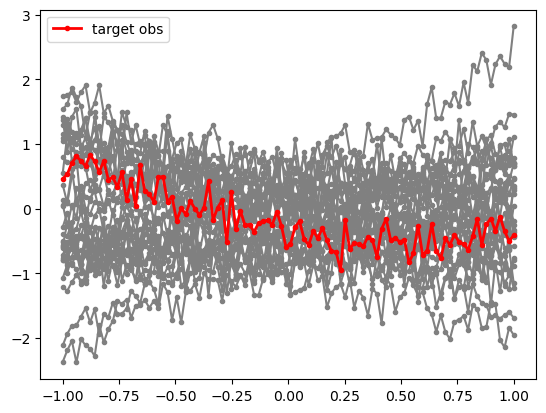

In [29]:
for i in range(30):
    plt.plot(y, samples[i]['x'], marker='.', color='0.5')
plt.plot(y, obs['x'], marker='.', color='r', lw = 2, label = 'target obs')
plt.legend(loc=0)

Inference proceeds now as before, with the only difference that the size of the data vector (`num_features`) is now larger.

In [30]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = Nbins, num_params = 3, varnames = 'z')

    def forward(self, A, B):
        return self.logratios(A['x'], B['z'])

trainer = swyft.SwyftTrainer(accelerator = 'gpu', devices=1, max_epochs = 3, precision = 64)
dm = swyft.SwyftDataModule(samples, fractions = [0.8, 0.2, 0.0])
network = Network()
trainer.fit(network, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | logratios | LogRatioEstimator_1dim | 71.2 K
-----------------------------------------------------
71.2 K    Trainable params
0         Non-trainable params
71.2 K    Total params
0.570     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


Inference is done as before, now targeting the mock observation from above. We plot the three one-dimensional posteriors side by side.

You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 250it [00:00, ?it/s]

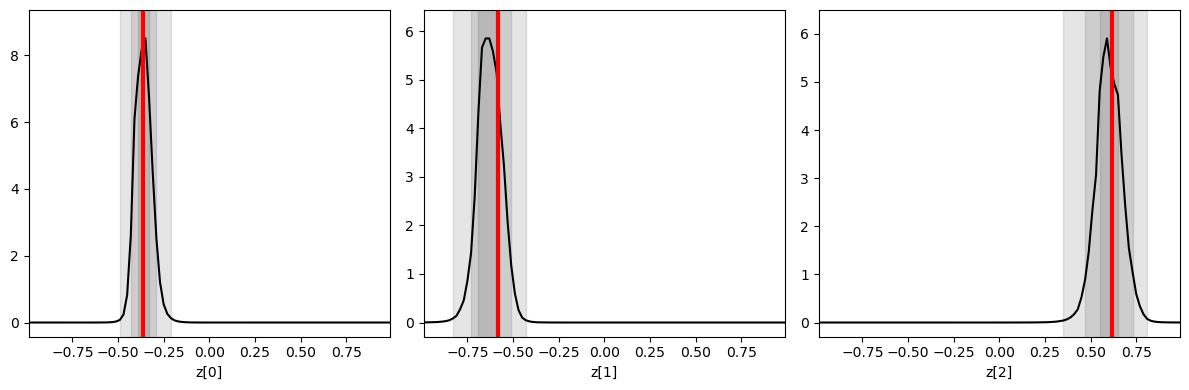

In [31]:
prior_samples = swyft.Samples(z = np.random.rand(100_000, 3)*2-1)
predictions = trainer.infer(network, obs, prior_samples)

fig, axes = plt.subplots(1, 3, figsize = (12, 4))
for i in range(3):
    swyft.plot_1d(predictions, "z[%i]"%i, ax = axes[i]); axes[i].axvline(obs['z'][i], color='r', lw=3.); axes[i].set_xlabel("z[%i]"%i)
plt.tight_layout()

### Exercises

1. Estimate correlations and make corner plot.

In [32]:
# Results go here

2. Add non-Gaussian noise to the data. For instance, you can use `ngn = np.random.poisson(lam = 3/Nbins, size = (N, Nbins))*5`. This will produce on average 3 strong peaks in the data (a radio astronomer might think of RFI).

- Run the network training again and see that parameter inference still works.
- If you couldn't use a neural net, what would you use instead?



In [33]:
# Results go here